In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.xmargin'] = 0

In [2]:

# files = ['oam3_range30', 'oam3_range10', 'oam1_range10']
# files = ['oam3_range10', 'oam3_range10_xi04']
files = ['corr_oam3_range10', 'xi04_rs50']
data = {}
for file in files:
    data[file] = np.load(f'data/dsa_{file}.npy', allow_pickle=True).item()

data[files[1]]['+pp(constrained)'] = data[files[1]]['+pp(constrained)']

In [3]:
# calculate bands for correlations

fit = '+pp(constrained)'
confid = 68

for file in data:
    for irep in range(len(data[file][fit])):
        data[file][fit][irep]['<cos(phi_Dp + phi_kp)>'] = data[file][fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] - data[file][fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
        data[file][fit][irep]['<cos(phi_Dp - phi_kp)>'] = data[file][fit][irep]['<cos(phi_Dp)cos(phi_kp)>'] + data[file][fit][irep]['<sin(phi_Dp)sin(phi_kp)>']
    

bands = {}
all_errors = {}
tt_errors = {}
for file in data:
    bands[file] = {}
    for obj in ['lower', 'upper', 'mean']:
        bands[file][obj] = {}

    for corr in ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']:
        corr_reps = [rep[corr] for rep in data[file][fit]]
        bands[file]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0, method='inverted_cdf')
        bands[file]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0, method='inverted_cdf')
        bands[file]['mean'][corr] = np.mean(corr_reps, axis=0)


    lumi = 100
    all_errors[file] = np.sqrt(1/(2*lumi*np.array(data[file][fit][0]['denom'])))
    tt_errors[file] = np.sqrt(2.0/(2*lumi*np.array(data[file][fit][0]['denom'])))


# get kinematics + make labels

space = data[files[0]]['space']
pT_values = data[files[0]]['pT values']
roots = data[files[1]]['roots']

space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])

info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'
for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            # info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$' + '\n'
            # info_text += fr'$\overline{{Q}}_0 \, = 2 \, \mathrm{{GeV}}$' + '\n'
            pass
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        elif var == 't':
            info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


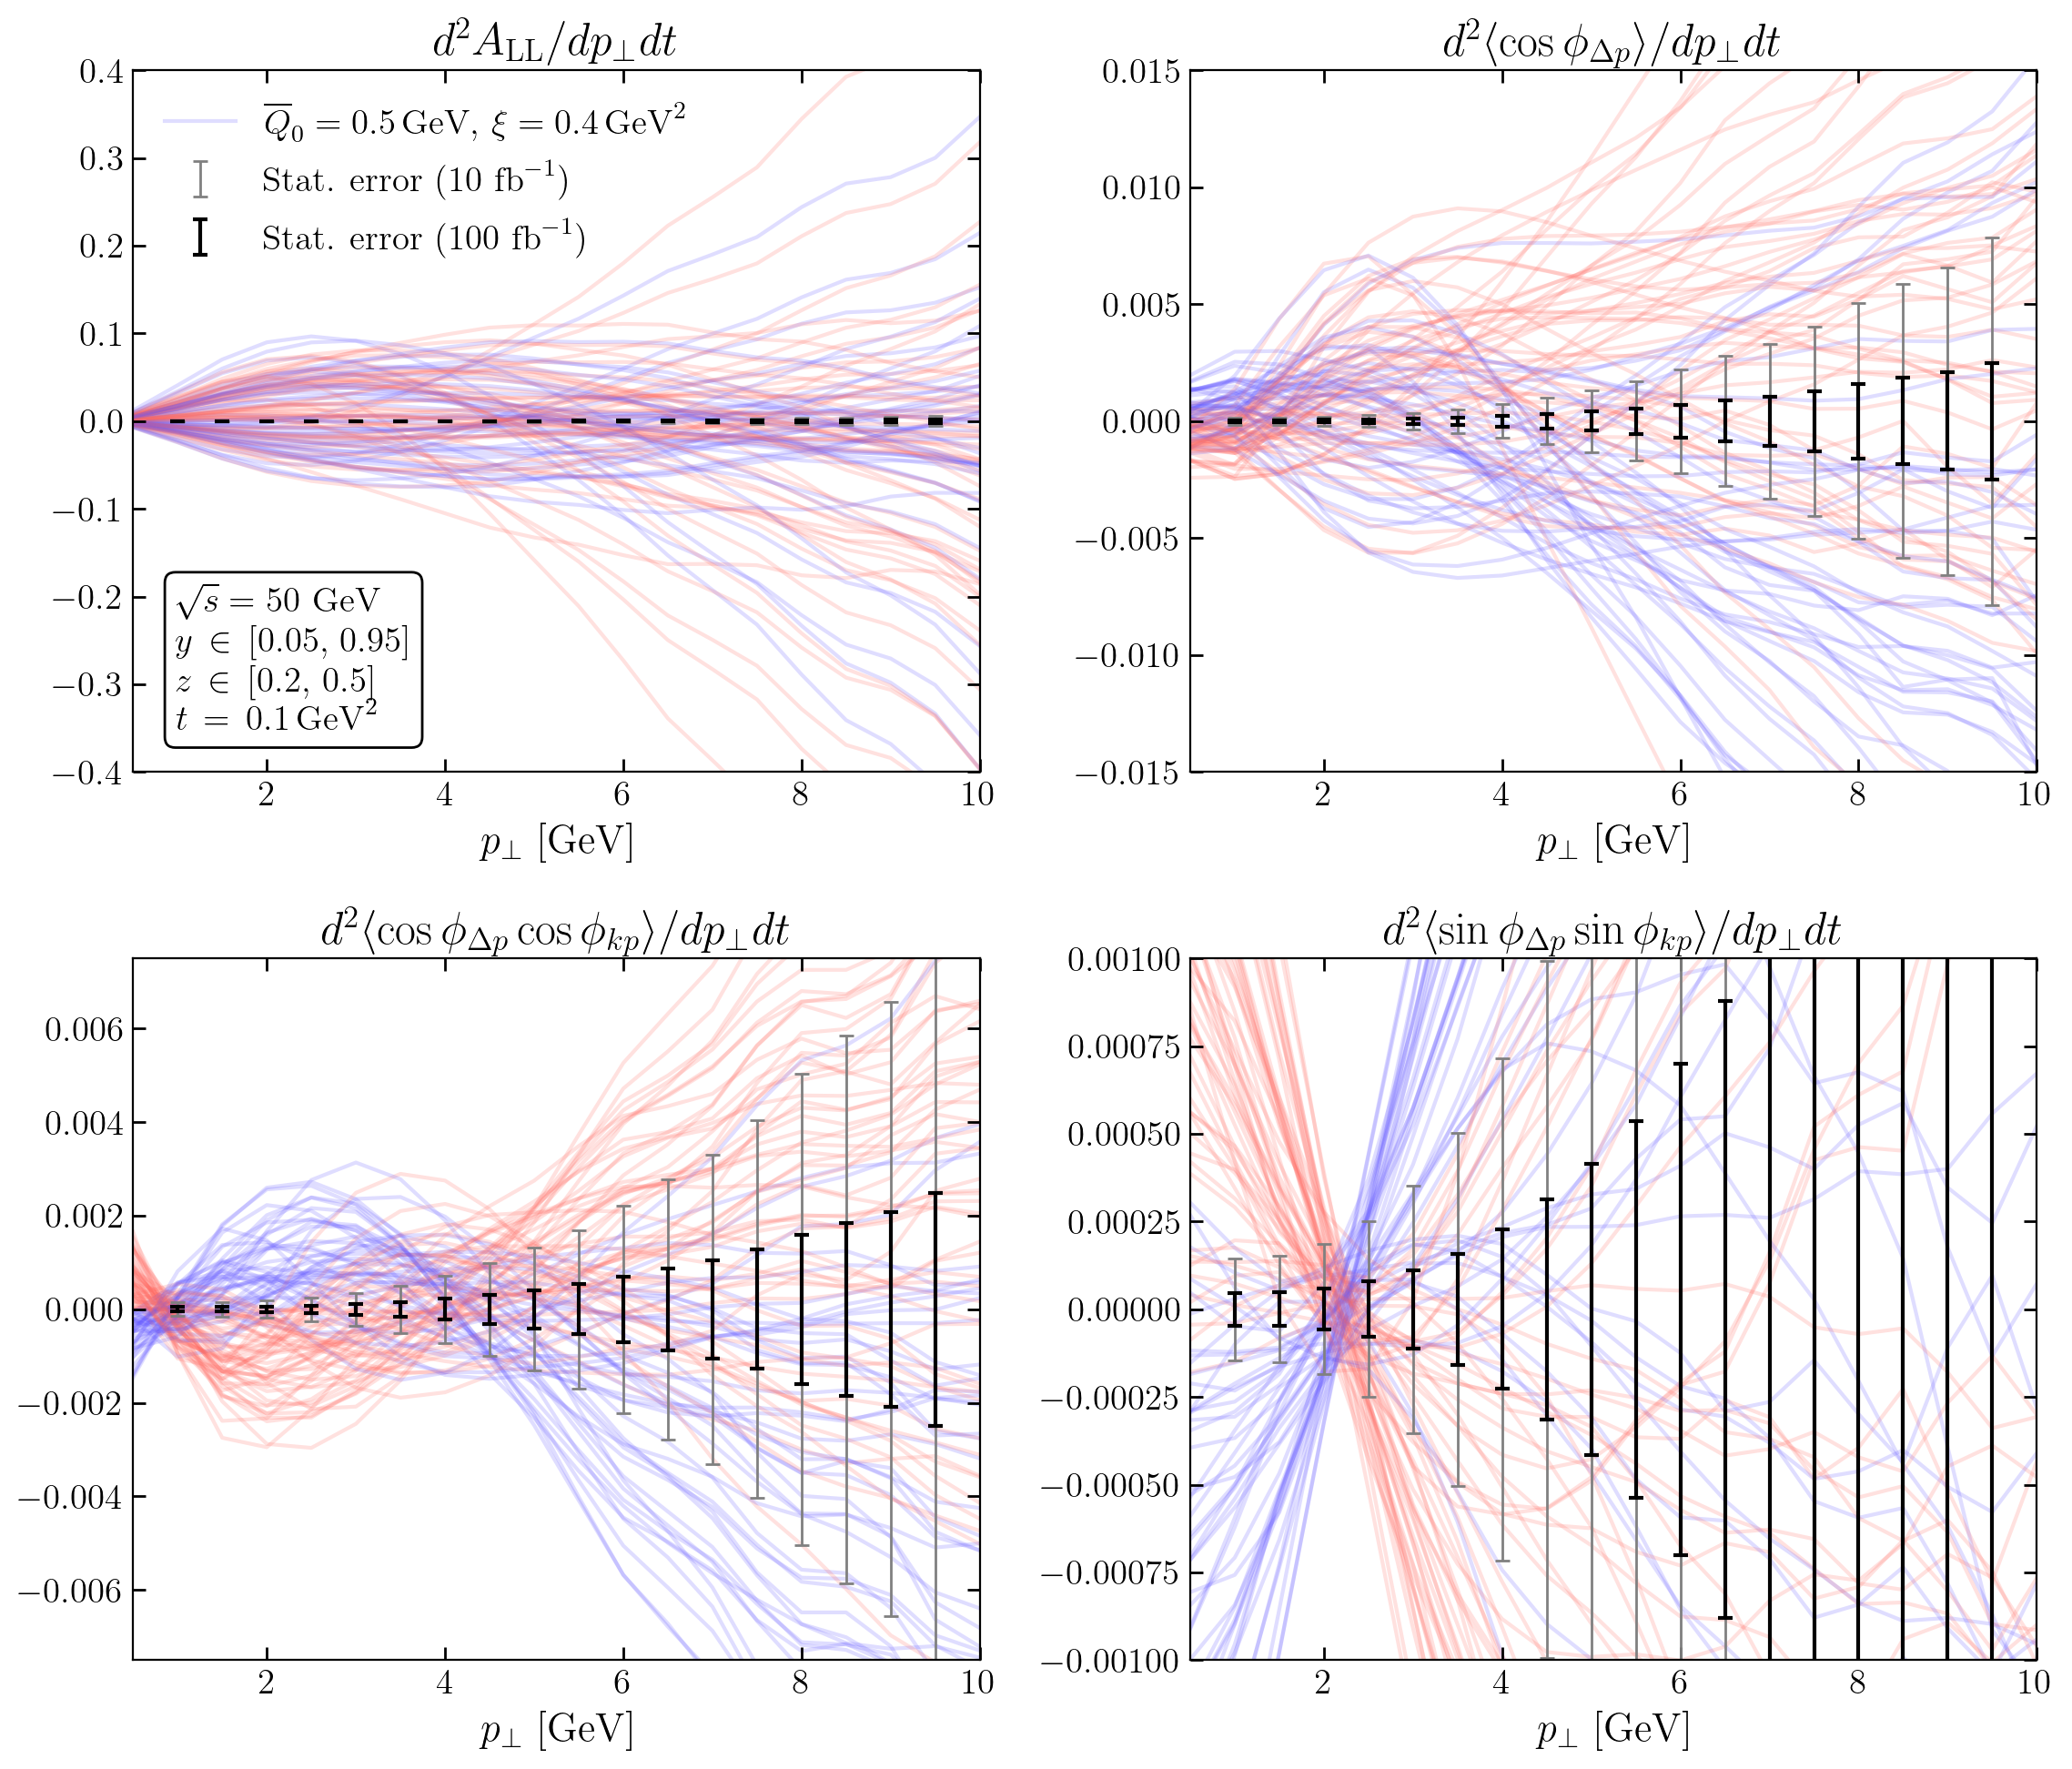

In [7]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

plot_bands = False
alt_defs = False
plot_stat_errors = True

colors = ['#FF6961', '#6257ff']
labels = ['', r'$\overline{Q}_0 = 0.5 \, \mathrm{GeV}, \, \xi = 0.4 \, \mathrm{GeV}^2$']

corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
if alt_defs: 
    corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

for ifile, file in enumerate(data):
    if ifile != 1: continue
    for icorr, corr in enumerate(corrs):
        if plot_bands:
            axs[icorr].fill_between(pT_values, bands[file]['lower'][corr], bands[file]['upper'][corr], color=colors[ifile], alpha=0.3, label=labels[ifile])
        
        else:
            for irep, rep in enumerate(data[file][fit]):
                if rep[corrs[2]][0] > 0: color = colors[0]
                else: color = colors[1]
                if irep == 0:
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=color, label=labels[ifile], zorder=1)
                else: 
                    axs[icorr].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=color, zorder=1)


err_colors = ['gray', 'black']

if plot_stat_errors:
    for ifile, file in enumerate(files):
        if ifile != 1: continue
        for icorr, corr in enumerate(corrs):
            if corr == '<1>': error = all_errors[file]
            else: error = tt_errors[file]
            # if plot_bands:
            axs[icorr].errorbar(
                    pT_values[1:-1], np.zeros(error[1:-1].shape), yerr=np.sqrt(10)*error[1:-1], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='gray', markersize=0, 
                    label=rf'Stat. error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
            )
            axs[icorr].errorbar(
                    pT_values[1:-1], np.zeros(error[1:-1].shape), yerr=error[1:-1], fmt='o',
                    capsize=3, elinewidth=1.5, capthick=1.5, color='black', markersize=0, 
                    label=rf'Stat. error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
            )
                    
 
# axs[0].axhline(y=1, color='grey', linestyle=':')
# axs[0].axhline(y=-1, color='grey', linestyle=':')
# axs[0].axhline(y=0, color='lightgray', linestyle='--')
axs[0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0].set_title(fr'$ d^{num_label} A_{{\mathrm{{LL}}}} / {den_label} $')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend(frameon=False, fontsize=14)
axs[0].text(
    0.05, 0.05, info_text, 
    transform=axs[0].transAxes,
    ha='left', va='bottom', 
    fontsize=14, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
)
# axs[0].semilogy()
axs[0].set_ylim([-0.4, 0.4])

# axs[1].axhline(y=0, color='lightgray', linestyle='--')
axs[1].set_xlabel(r'$p_\perp$ [GeV]')
axs[1].set_title(fr'$ d^{num_label} \langle \cos \phi_{{\Delta p}} \rangle / {den_label} $')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[1].legend(frameon=False)
axs[1].set_ylim([-0.015, 0.015])
# axs[1].semilogy()


# axs[2].axhline(y=0, color='lightgray', linestyle='--')
axs[2].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos (\phi_{{\Delta p}} + \phi_{{k p}}) \rangle / {den_label} $')
else: 
    axs[2].set_title(fr'$ d^{num_label}  \langle \cos\phi_{{\Delta p}} \cos\phi_{{k p}} \rangle / {den_label} $')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[2].legend(frameon=False)
axs[2].set_ylim([-0.0075, 0.0075])
# axs[2].semilogy()

# axs[3].axhline(y=0, color='lightgray', linestyle='--')
axs[3].set_xlabel(r'$p_{\perp}$ [GeV]')
if alt_defs:
    axs[3].set_title(fr'$ d^{num_label} \langle \cos(\phi_{{\Delta p}} - \phi_{{k p}})  \rangle / {den_label} $')
else:
    axs[3].set_title(fr'$ d^{num_label} \langle \sin\phi_{{\Delta p}} \sin\phi_{{k p}}  \rangle / {den_label} $')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
# axs[3].legend(frameon=False)
# axs[3].set_ylim([-0.004, 0.004])
axs[3].set_ylim([-0.001, 0.001])
# axs[3].semilogy()

plt.tight_layout()
plt.show()

# if plot_bands:
#     fig.savefig('plots/dsa_band_error_xi04_50rs.pdf', dpi=400, bbox_inches="tight") 
# else:
#     pass
#     # fig.savefig('plots/dsa_lines_constraints.pdf', dpi=400, bbox_inches="tight")


In [9]:
# study correlations with oam

dj = dijet.DIJET(constrained_moments=True, fit_type='pp')

xs = np.logspace(-6, -1, 50)
oamds = {} 
for func in ['Lq', 'LG']:
    oamds[func] = []
    
for irep, rep in enumerate(data[files[0]]['+pp(constrained)']):
    dj.set_params(irep+1)
    
    oamds['Lq'].append([dj.get_Lsinglet(x, 10) for x in xs])
    oamds['LG'].append([dj.get_LG(x, 10) for x in xs])
    


--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10.csv
--> loaded replica 1
--> loaded replica 1
--> loaded replica 2
--> loaded replica 3
--> loaded replica 4
--> loaded replica 5
--> loaded replica 6
--> loaded replica 7
--> loaded replica 8
--> loaded replica 9
--> loaded replica 10
--> loaded replica 11
--> loaded replica 12
--> loaded replica 13
--> loaded replica 14
--> loaded replica 15
--> loaded replica 16
--> loaded replica 17
--> loaded replica 18
--> loaded replica 19
--> loaded replica 20
--> loaded replica 21
--> loaded replica 22
--> loaded replica 23
--> loaded replica 24
--> loaded replica 25
--> loaded replica 26
--> loaded replica 27
--> loaded replica 28
--> loaded replica 29
--> loaded replica 30
--> loaded replica 31
--

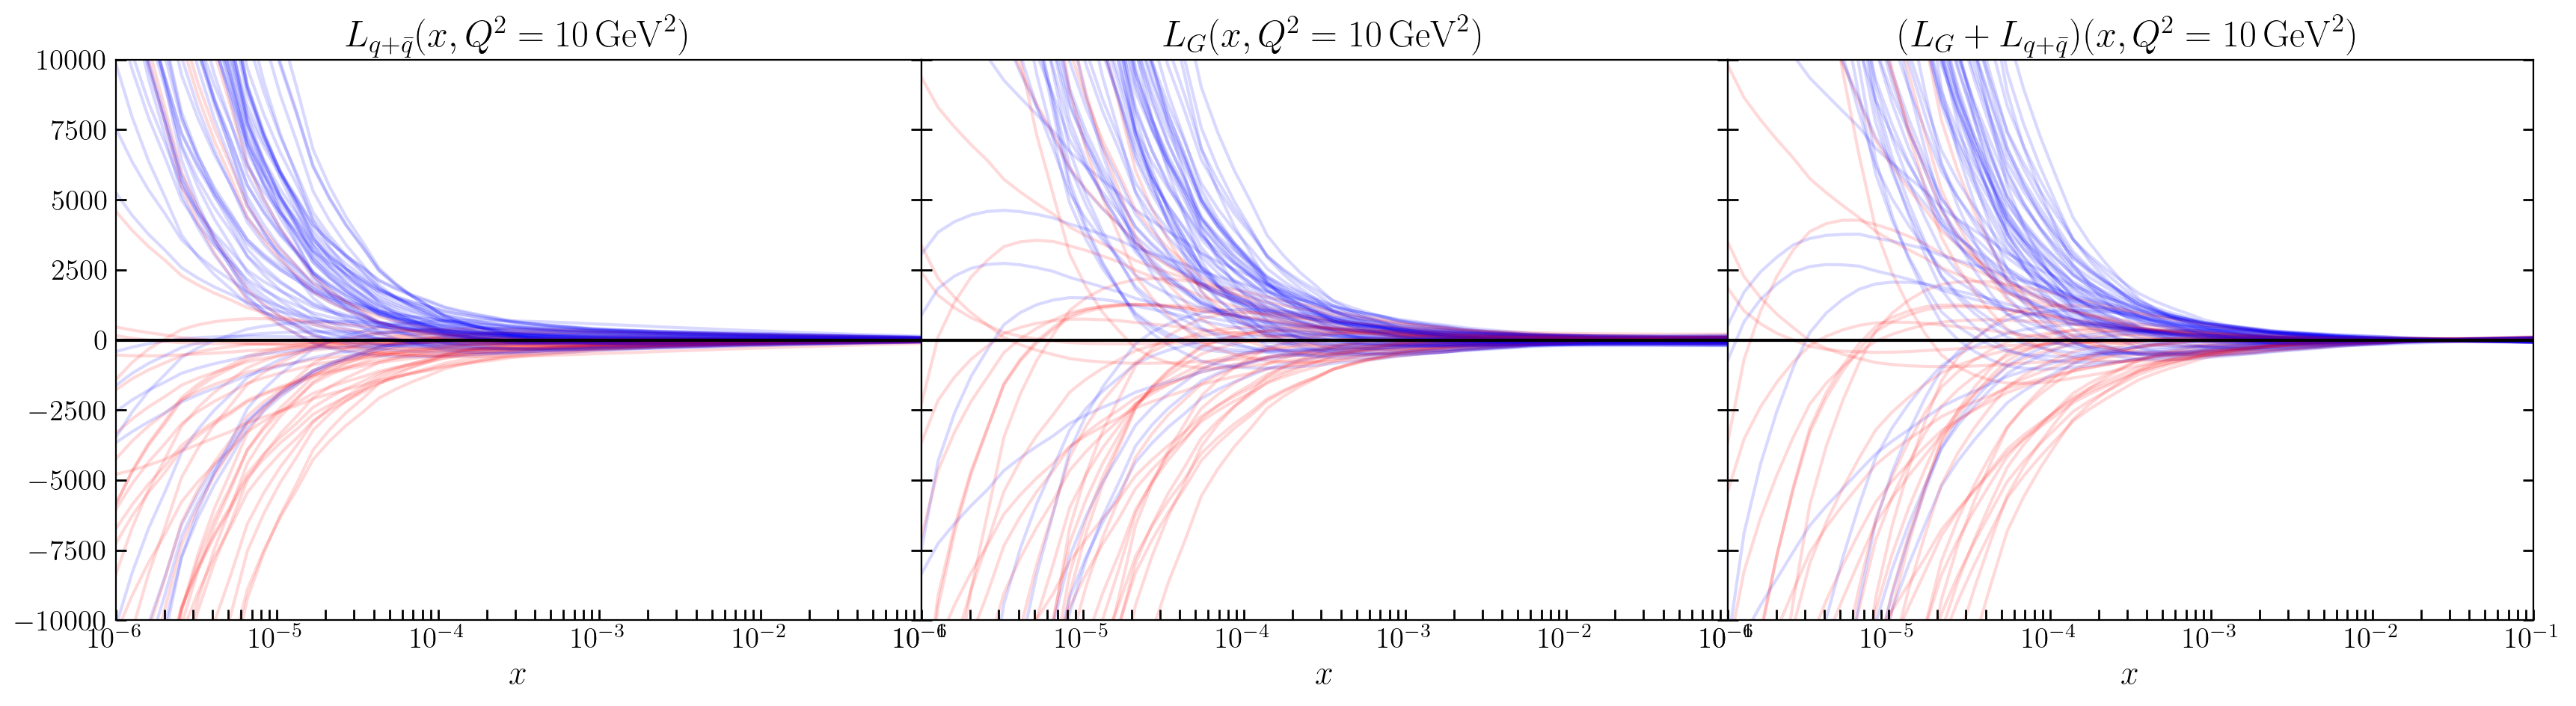

In [63]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 1, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows), sharey=True, gridspec_kw={'wspace': 0})

# corr = '<cos(phi_Dp)>'
corr = '<sin(phi_Dp)sin(phi_kp)>'
# corr = '<cos(phi_Dp)cos(phi_kp)>'
for irep, rep in enumerate(data[files[0]]['+pp(constrained)']):
    if rep[corr][0] > 0: color = 'blue'
    else: color = 'red'

    ax[0].plot(xs, np.array(oamds['Lq'][irep]), alpha=0.15, color=color, zorder=1)
    ax[1].plot(xs, np.array(oamds['LG'][irep]), alpha=0.15, color=color, zorder=1)
    ax[2].plot(xs, np.array(oamds['LG'][irep]) + np.array(oamds['Lq'][irep]), alpha=0.15, color=color, zorder=1)
                    

ax[0].axhline(y=0, color='black', linestyle='-')
ax[0].set_xlabel(r'$x$')
ax[0].set_title(r'$ L_{q+\bar{q}}(x, Q^2= 10\, \mathrm{GeV}^2 )$')
ax[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
# ax[0].legend(frameon=False, fontsize=14)
ax[0].semilogx()
ax[0].set_ylim([-10000, 10000])
# ax[0].set_ylim([-2.5, 2.5])
# ax[0].set_xmargin(0)   

ax[1].axhline(y=0, color='black', linestyle='-')
ax[1].set_xlabel(r'$x$')
ax[1].set_title(r'$ L_G(x, Q^2 = 10\, \mathrm{GeV}^2 )$')
ax[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
# ax[0].legend(frameon=False, fontsize=14)
ax[1].semilogx()
# ax[1].set_ylim([-2.5, 2.5])
# ax[1].set_ylim([-10000, 10000])
# ax[1].set_xmargin(0)  

ax[2].axhline(y=0, color='black', linestyle='-')
ax[2].set_xlabel(r'$x$')
ax[2].set_title(r'$ (L_G + L_{q+\bar{q}})(x, Q^2 = 10\, \mathrm{GeV}^2 )$')
ax[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=False)
# ax[0].legend(frameon=False, fontsize=14)
ax[2].semilogx()
# ax[2].set_ylim([-200, 200])
# ax[2].set_ylim([-10000, 10000])
# ax[1].set_xmargin(0)  

plt.tight_layout()
plt.show()

# if plot_bands:
#     fig.savefig('plots/dsa_band_error_xi04_50rs.pdf', dpi=400, bbox_inches="tight") 
# else:
#     pass
#     # fig.savefig('plots/dsa_lines_constraints.pdf', dpi=400, bbox_inches="tight")


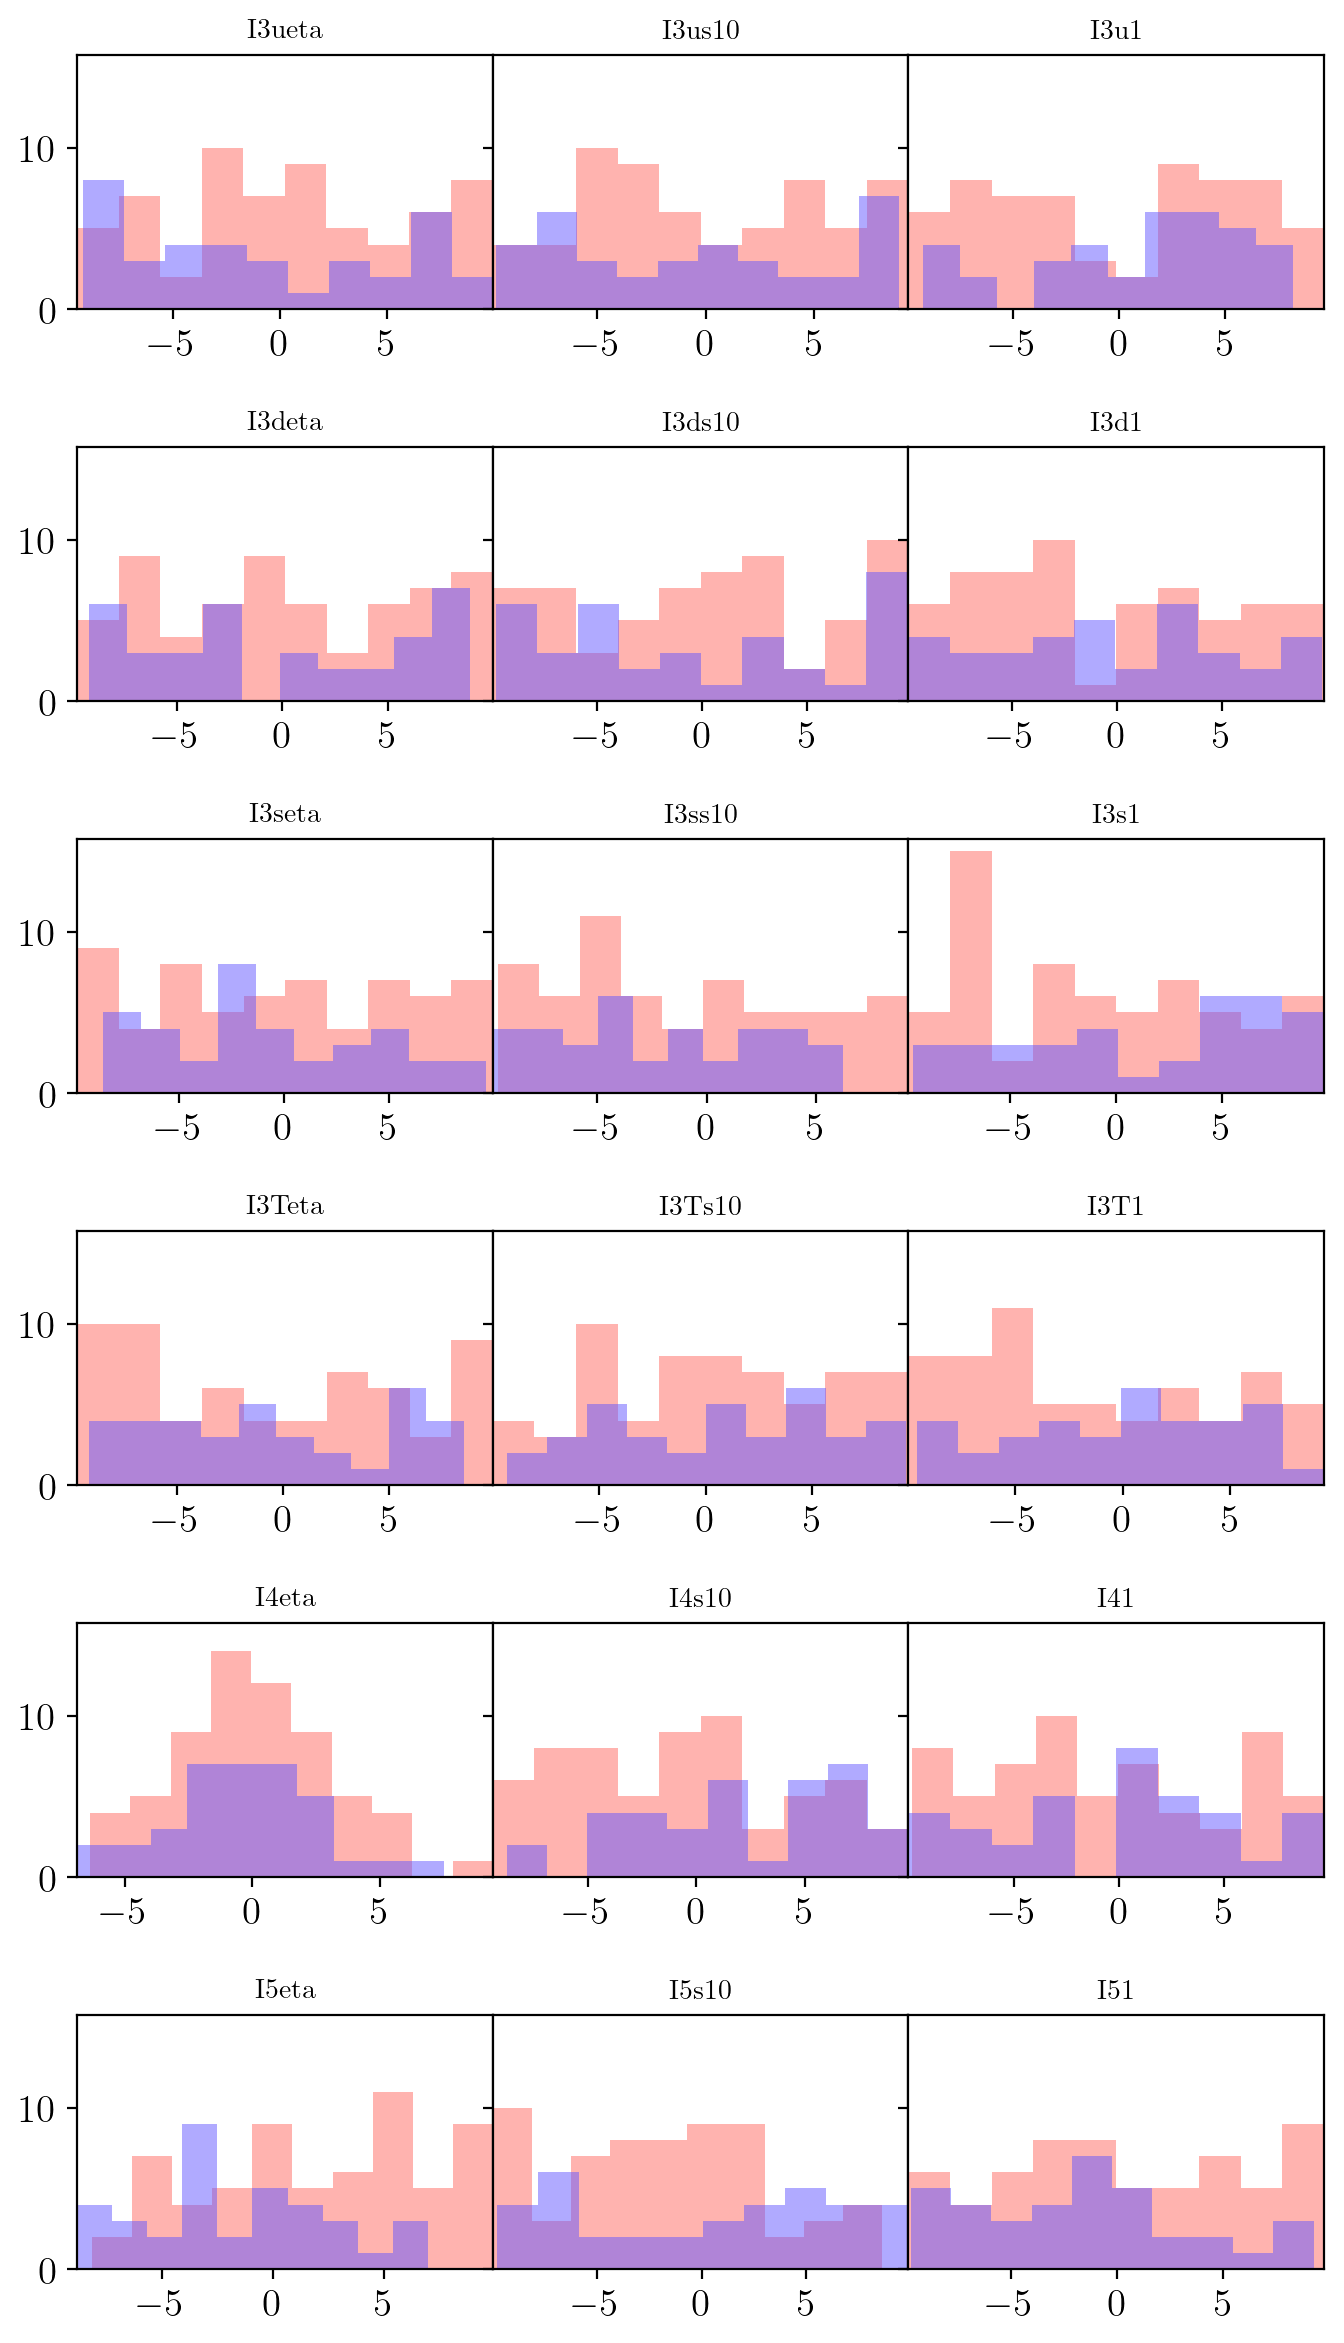

In [60]:
asp_ratio = 3.5/3
psize = 2
nrows, ncols = 6, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows), sharey=True, gridspec_kw={'wspace': 0})
axes = ax.flatten()

corr = '<sin(phi_Dp)sin(phi_kp)>'
reps = [data[files[0]]['+pp(constrained)'][i][corr][0] for i in range(len(data[files[0]]['+pp(constrained)']))]
mask = np.array(reps) > 0

moms = dj.mom_params.iloc[:len(mask)]
pos = moms[mask]
neg = moms[~mask]

for i, col in enumerate(dj.mom_params.columns):
    if col == 'nrep': continue
    # print(col)
    ax = axes[i-1]
    ax.hist(pos[col], bins=10, color=colors[0], alpha=0.5)
    ax.hist(neg[col], bins=10, color=colors[1], alpha=0.5)
    ax.set_title(col, fontsize=10)

# Hide unused axes (in case df has fewer than 18 columns)
# for j in range(len(dj.mom_params.columns), len(axes)):
#     axes[j].axis('off')

# Tight layout to reduce spacing
plt.tight_layout()
plt.show()